In [1]:
#pip install imblearn torch torchvision torchtext torchdata tensorflow nbformat>=4.2.0

In [2]:
#pip install tensorflow-gpu==2.10

In [3]:
#pip install numpy==1.24.4

In [4]:
import tensorflow as tf

# This will return a list of available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Or simply check if at least one GPU is available
print("Is GPU available?", len(gpus) > 0)

GPUs available: []
Is GPU available? False


In [5]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import sys


In [8]:
# Load the datasets
wadi_attack_cleaned_path = 'WADI_cleaned_for_modeling.csv'

# Read the CSV files into pandas DataFrames
df = pd.read_csv(wadi_attack_cleaned_path, header=0)

# Display the first few rows of each dataframe to understand the structure of the data
df.columns = df.columns.str.strip()
df.head()

,Timestamp,Day,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,2017-10-09 00:00:00,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
1,2017-10-09 00:00:00,2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2,2017-10-09 00:00:00,2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
3,2017-10-09 00:00:00,2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
4,2017-10-09 00:00:00,2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1


In [9]:
df.columns


Index(['Timestamp', 'Day', 'Row', 'Date', 'Time', '1_AIT_001_PV',
       '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV', '1_AIT_005_PV',
       ...
       '3_MV_002_STATUS', '3_MV_003_STATUS', '3_P_001_STATUS',
       '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS',
       'LEAK_DIFF_PRESSURE', 'PLANT_START_STOP_LOG',
       'TOTAL_CONS_REQUIRED_FLOW', 'Attack LABLE (1:No Attack, -1:Attack)'],
      dtype='object', length=133)

In [10]:
# Step 2: Identify label column
df.columns = df.columns.str.strip()
label_col = [col for col in df.columns if 'Attack' in col][0]  # dynamic detection
print(f"Detected label column: {label_col}")

# Step 3: Drop non-feature columns
drop_cols = ['Row', 'Date', 'Time', 'Timestamp', label_col]
features = df.drop(columns=drop_cols, errors='ignore')
features = features.select_dtypes(include=['float64', 'int64'])  # Keep only numeric columns
labels = df[label_col]

# Step 4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# Step 5: Train-test split (80/20), stratify to balance attack/normal
X_train, X_test, y_train, y_test_rf = train_test_split(
    X_scaled, labels, test_size=0.0005, stratify=labels, random_state=42
)

# Shape summary
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Label distribution in train:\n{pd.Series(y_train).value_counts()}")
print(f"Label distribution in test:\n{pd.Series(y_test_rf).value_counts()}")

Detected label column: Attack LABLE (1:No Attack, -1:Attack)


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Train shape: (172714, 127), Test shape: (87, 127)
Label distribution in train:
Attack LABLE (1:No Attack, -1:Attack)
 1    162742
-1      9972
Name: count, dtype: int64
Label distribution in test:
Attack LABLE (1:No Attack, -1:Attack)
 1    82
-1     5
Name: count, dtype: int64


# Modelling

🔹 Baseline Random Forest Performance:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        82

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



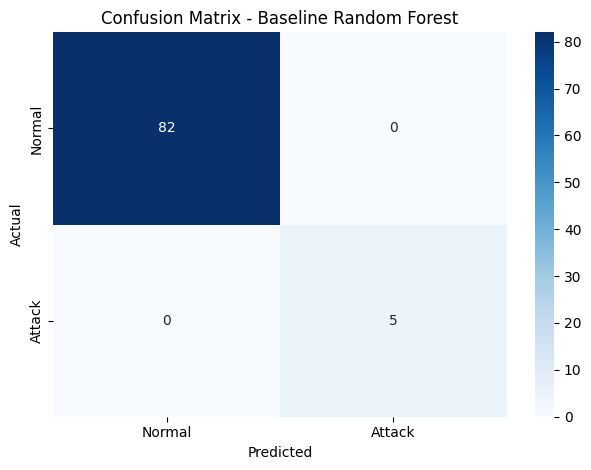

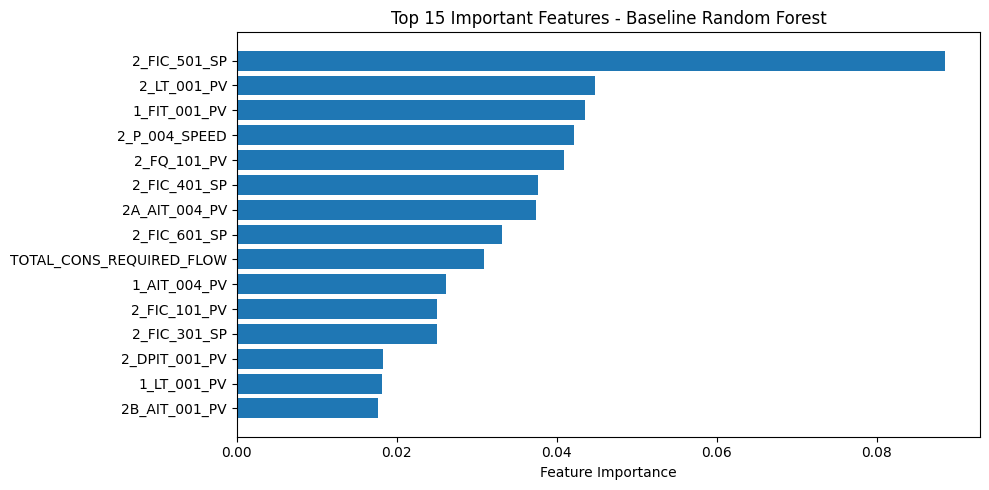

Model saved to random_forest_model.pkl
Features used saved to features_used.csv
Features used saved to features_used.pkl
Scaler saved to scaler.pkl


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Basic model
rf_basic = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_basic.fit(X_train, y_train)
rf_proba = rf_basic.predict_proba(X_test)[:, 1]  # probability of class '1' (attack)


# Predict
y_pred_basic = rf_basic.predict(X_test)

# Evaluate
print("🔹 Baseline Random Forest Performance:")
print(classification_report(y_test_rf, y_pred_basic))
# confusion Matix
cm_basic = confusion_matrix(y_test_rf, y_pred_basic, labels=[1, -1])
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Baseline Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
importances_basic = rf_basic.feature_importances_
indices_basic = np.argsort(importances_basic)[-15:]
plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_basic)), importances_basic[indices_basic], align='center')
plt.yticks(range(len(indices_basic)), [features.columns[i] for i in indices_basic])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Baseline Random Forest')
plt.tight_layout()
plt.show()

# Step 6: Save the model

import joblib
# Save the model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_basic, model_filename)
print(f"Model saved to {model_filename}")


# save the features used in the model in csv format
features_filename = 'features_used.csv'
pd.Series(features.columns).to_csv(features_filename, index=False, header=False)
print(f"Features used saved to {features_filename}")

features_filename = 'features_used.pkl'
joblib.dump(features.columns.tolist(), features_filename)
print(f"Features used saved to {features_filename}")
# Save the scaler
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 2: Identify label column
df.columns = df.columns.str.strip()
label_col = [col for col in df.columns if 'Attack' in col][0]  # dynamic detection
print(f"Detected label column: {label_col}")

# Step 3: Drop non-feature columns
drop_cols = ['Row', 'Date', 'Time', 'Timestamp', label_col]
features = df.drop(columns=drop_cols, errors='ignore')
features = features.select_dtypes(include=['float64', 'int64'])  # Keep only numeric columns
labels = df[label_col]

print(f"Original dataset shape: {df.shape}")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Step 4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# For OOB evaluation: Use ALL data (no train/test split needed)
X = X_scaled  # All features (100% of data)
y = labels    # All labels (100% of data)

print(f"\n🎯 Data prepared for OOB Random Forest:")
print(f"X (features) shape: {X.shape}")
print(f"y (labels) shape: {y.shape}")
print(f"Using 100% of data for training with OOB evaluation")

# Display label distribution
print(f"\nLabel distribution in full dataset:")
label_counts = pd.Series(y).value_counts()
print(label_counts)
print(f"Class balance: {label_counts.values}")

# Optional: Keep a small holdout set for final validation (if desired)
# This is NOT required for OOB, but useful for final model validation
KEEP_HOLDOUT = False  # Set to False if you want to use 100% for training

if KEEP_HOLDOUT:
    print(f"\n📊 Creating optional holdout set for final validation...")
    # Keep 5% as holdout, use 95% for OOB training
    X_train_oob, X_test, y_train_oob, y_test_rf = train_test_split(
        X, y, test_size=0.05, stratify=y, random_state=42
    )
    
    # Use 95% for OOB training
    X = X_train_oob
    y = y_train_oob
    
    print(f"OOB Training data: {X.shape}")
    print(f"Holdout test data: {X_test.shape}")
    print(f"OOB Label distribution:\n{pd.Series(y).value_counts()}")
    print(f"Holdout Label distribution:\n{pd.Series(y_test_rf).value_counts()}")
else:
    print(f"\n🎯 Using 100% of data for OOB training (no holdout)")
    X_test = None
    y_test_rf = None

# Summary
print(f"\n{'='*60}")
print(f"📋 FINAL DATA SUMMARY FOR OOB RANDOM FOREST")
print(f"{'='*60}")
print(f"Features used for training: {X.shape[0]:,} samples × {X.shape[1]} features")
print(f"Total classes: {len(np.unique(y))}")
print(f"Class labels: {np.unique(y)}")
print(f"Scaling method: MinMaxScaler")
print(f"Ready for OOB evaluation: ✅")

if KEEP_HOLDOUT and X_test is not None:
    print(f"Optional holdout set: {X_test.shape[0]:,} samples")
    print(f"Holdout percentage: {(len(X_test)/(len(X) + len(X_test))*100):.1f}%")

print(f"\n🚀 Ready to train Random Forest with OOB evaluation!")
print(f"Next: Use X and y in your Random Forest model")

Detected label column: Attack LABLE (1:No Attack, -1:Attack)
Original dataset shape: (172801, 133)
Features shape: (172801, 127)
Labels shape: (172801,)


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))



🎯 Data prepared for OOB Random Forest:
X (features) shape: (172801, 127)
y (labels) shape: (172801,)
Using 100% of data for training with OOB evaluation

Label distribution in full dataset:
Attack LABLE (1:No Attack, -1:Attack)
 1    162824
-1      9977
Name: count, dtype: int64
Class balance: [162824   9977]

🎯 Using 100% of data for OOB training (no holdout)

📋 FINAL DATA SUMMARY FOR OOB RANDOM FOREST
Features used for training: 172,801 samples × 127 features
Total classes: 2
Class labels: [-1  1]
Scaling method: MinMaxScaler
Ready for OOB evaluation: ✅

🚀 Ready to train Random Forest with OOB evaluation!
Next: Use X and y in your Random Forest model


🚀 Training Random Forest on 100% of the data...
📊 Out-of-Bag (OOB) Score: 0.9996

🔹 Optimized Random Forest OOB Performance:
Accuracy:  0.9996
Precision: 0.9996
Recall:    0.9996
F1-Score:  0.9996

📋 Detailed OOB Classification Report:
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      9977
           1       1.00      1.00      1.00    162824

    accuracy                           1.00    172801
   macro avg       1.00      1.00      1.00    172801
weighted avg       1.00      1.00      1.00    172801



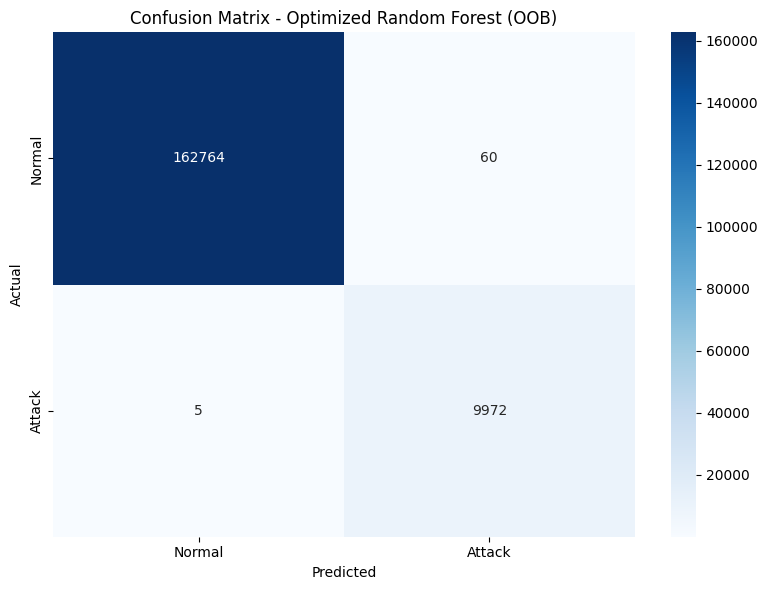

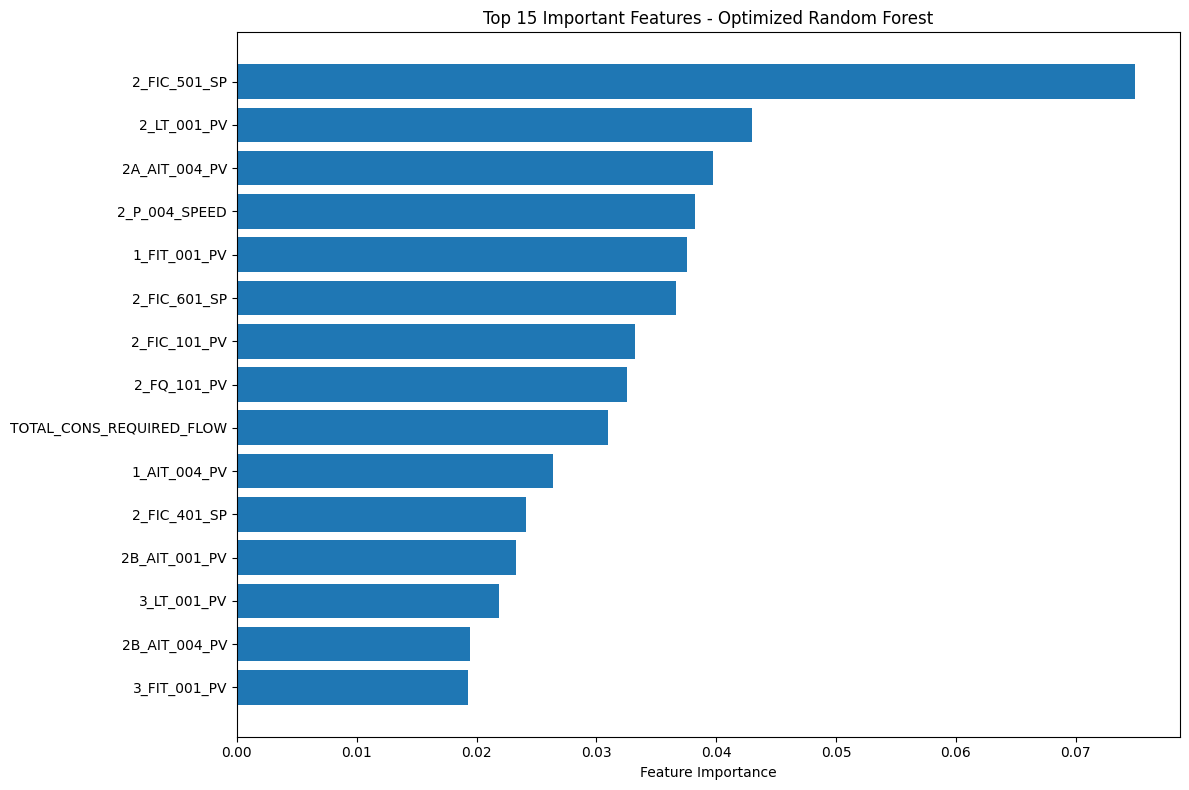


🔝 Top 10 Most Important Features:
                      feature  importance
34               2_FIC_501_SP    0.074944
61                2_LT_001_PV    0.042956
104             2A_AIT_004_PV    0.039696
87              2_P_004_SPEED    0.038248
5                1_FIT_001_PV    0.037527
37               2_FIC_601_SP    0.036639
21               2_FIC_101_PV    0.033188
41                2_FQ_101_PV    0.032542
126  TOTAL_CONS_REQUIRED_FLOW    0.030944
3                1_AIT_004_PV    0.026394

📈 Model Performance Summary:
Trees in Forest:        500
Max Depth:             20
OOB Score:             0.9996
Training Data Used:    100% (172801 samples)
Classes:               [-1  1]
Class Distribution:    {-1: 9977, 1: 162824}

🧪 Additional Test Set Evaluation:


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Optimized Random Forest with OOB evaluation
rf_optimized = RandomForestClassifier(
    # Core parameters for better performance
    n_estimators=500,              # More trees for better performance
    max_depth=20,                  # Deeper trees for complex patterns
    min_samples_split=5,           # Prevent overfitting
    min_samples_leaf=2,            # Prevent overfitting
    max_features='sqrt',           # Good default for classification
    
    # Bootstrap and sampling
    bootstrap=True,                # Required for OOB
    oob_score=True,               # Enable OOB scoring
    
    # Performance optimization
    n_jobs=-1,                    # Use all CPU cores
    random_state=42,              # Reproducibility
    
    # Handle class imbalance
    class_weight='balanced',      # Auto-balance classes
    
    # Additional performance tuning
    max_samples=0.8,              # Use 80% of samples per tree (reduces overfitting)
    ccp_alpha=0.0,               # Cost complexity pruning (0.0 = no pruning)
)

# Train on ALL data (X and y, not X_train/y_train)
print("🚀 Training Random Forest on 100% of the data...")
rf_optimized.fit(X, y)  # Use full dataset

# Get OOB performance metrics
oob_score = rf_optimized.oob_score_
print(f"📊 Out-of-Bag (OOB) Score: {oob_score:.4f}")

# Get OOB predictions for detailed analysis
oob_decision = rf_optimized.oob_decision_function_
oob_predictions = np.argmax(oob_decision, axis=1)

# Convert to your class labels (assuming your classes are 1 and -1)
unique_classes = np.unique(y)
oob_pred_labels = unique_classes[oob_predictions]

# Get OOB probabilities for the positive class (attack)
if len(unique_classes) == 2:
    # For binary classification, get probability of positive class
    positive_class_idx = np.where(unique_classes == 1)[0][0] if 1 in unique_classes else 1
    rf_proba_oob = oob_decision[:, positive_class_idx]
else:
    rf_proba_oob = np.max(oob_decision, axis=1)

# Calculate detailed OOB metrics
oob_accuracy = accuracy_score(y, oob_pred_labels)
oob_precision = precision_score(y, oob_pred_labels, average='weighted')
oob_recall = recall_score(y, oob_pred_labels, average='weighted')
oob_f1 = f1_score(y, oob_pred_labels, average='weighted')

print("\n🔹 Optimized Random Forest OOB Performance:")
print(f"Accuracy:  {oob_accuracy:.4f}")
print(f"Precision: {oob_precision:.4f}")
print(f"Recall:    {oob_recall:.4f}")
print(f"F1-Score:  {oob_f1:.4f}")

# Detailed classification report using OOB predictions
print("\n📋 Detailed OOB Classification Report:")
print(classification_report(y, oob_pred_labels))

# Confusion Matrix using OOB predictions
plt.figure(figsize=(8, 6))
cm_oob = confusion_matrix(y, oob_pred_labels, labels=[1, -1])
sns.heatmap(cm_oob, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Optimized Random Forest (OOB)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance Analysis
importances_optimized = rf_optimized.feature_importances_
indices_optimized = np.argsort(importances_optimized)[-15:]

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices_optimized)), importances_optimized[indices_optimized], align='center')
plt.yticks(range(len(indices_optimized)), [features.columns[i] for i in indices_optimized])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Optimized Random Forest')
plt.tight_layout()
plt.show()

# Additional: Feature importance DataFrame for analysis
feature_importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': importances_optimized
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Model Performance Summary
print(f"\n📈 Model Performance Summary:")
print(f"{'='*50}")
print(f"Trees in Forest:        {rf_optimized.n_estimators}")
print(f"Max Depth:             {rf_optimized.max_depth}")
print(f"OOB Score:             {oob_score:.4f}")
print(f"Training Data Used:    100% ({len(X)} samples)")
print(f"Classes:               {unique_classes}")
print(f"Class Distribution:    {dict(zip(*np.unique(y, return_counts=True)))}")

# Optional: Test on holdout data if you still want to use X_test
if 'X_test' in locals() and 'y_test_rf' in locals():
    print(f"\n🧪 Additional Test Set Evaluation:")
    y_pred_test = rf_optimized.predict(X_test)
    test_accuracy = accuracy_score(y_test_rf, y_pred_test)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print("\nTest Set Classification Report:")
    print(classification_report(y_test_rf, y_pred_test))

# Save the optimized model
print(f"\n💾 Saving Model and Components...")
model_filename = 'random_forest_optimized_oob.pkl'
joblib.dump(rf_optimized, model_filename)
print(f"✅ Model saved to {model_filename}")

# Save feature names
features_csv = 'features_used_optimized.csv'
pd.Series(features.columns).to_csv(features_csv, index=False, header=False)
print(f"✅ Features list saved to {features_csv}")

features_pkl = 'features_used_optimized.pkl'
joblib.dump(features.columns.tolist(), features_pkl)
print(f"✅ Features list saved to {features_pkl}")

# Save feature importance
importance_filename = 'feature_importance_optimized.pkl'
joblib.dump(feature_importance_df, importance_filename)
print(f"✅ Feature importance saved to {importance_filename}")

# Save scaler (if it exists)
if 'scaler' in locals():
    scaler_filename = 'scaler_optimized.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"✅ Scaler saved to {scaler_filename}")

print(f"\n🎯 Model training complete! Using OOB evaluation on 100% of your data.")
print(f"OOB Score provides unbiased performance estimate: {oob_score:.4f}")

In [13]:
# ...existing code...
print("Features used for training:")
print(features.columns.tolist())
# ...existing code...

Features used for training:
['1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV', '1_AIT_005_PV', '1_FIT_001_PV', '1_LS_001_AL', '1_LS_002_AL', '1_LT_001_PV', '1_MV_001_STATUS', '1_MV_002_STATUS', '1_MV_003_STATUS', '1_MV_004_STATUS', '1_P_001_STATUS', '1_P_002_STATUS', '1_P_003_STATUS', '1_P_004_STATUS', '1_P_005_STATUS', '1_P_006_STATUS', '2_DPIT_001_PV', '2_FIC_101_CO', '2_FIC_101_PV', '2_FIC_101_SP', '2_FIC_201_CO', '2_FIC_201_PV', '2_FIC_201_SP', '2_FIC_301_CO', '2_FIC_301_PV', '2_FIC_301_SP', '2_FIC_401_CO', '2_FIC_401_PV', '2_FIC_401_SP', '2_FIC_501_CO', '2_FIC_501_PV', '2_FIC_501_SP', '2_FIC_601_CO', '2_FIC_601_PV', '2_FIC_601_SP', '2_FIT_001_PV', '2_FIT_002_PV', '2_FIT_003_PV', '2_FQ_101_PV', '2_FQ_201_PV', '2_FQ_301_PV', '2_FQ_401_PV', '2_FQ_501_PV', '2_FQ_601_PV', '2_LS_001_AL', '2_LS_002_AL', '2_LS_101_AH', '2_LS_101_AL', '2_LS_201_AH', '2_LS_201_AL', '2_LS_301_AH', '2_LS_301_AL', '2_LS_401_AH', '2_LS_401_AL', '2_LS_501_AH', '2_LS_501_AL', '2_LS_601_AH', '2_LS_60

In [14]:
# ...existing code...
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test_rf shape:", y_test_rf.shape)
# ...existing code...

X_train shape: (172714, 127)
y_train shape: (172714,)


AttributeError: 'NoneType' object has no attribute 'shape'

In [16]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Ensure data is properly shaped
X_train = np.array(X_train).reshape(-1, X_train.shape[1]) if len(X_train.shape) == 1 else X_train
y_train = np.array(y_train).reshape(-1) if len(y_train.shape) == 1 else y_train
X_test = np.array(X_test).reshape(-1, X_test.shape[1]) if len(X_test.shape) == 1 else X_test
y_test_rf = np.array(y_test_rf).reshape(-1) if len(y_test_rf.shape) == 1 else y_test_rf

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# Grid Search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=2, n_jobs=1, verbose=1,
    scoring='f1_macro'
)
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
rf_tuned_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("🔹 Tuned Random Forest Performance:")
print("Best Params:", rf_grid.best_params_)
print(classification_report(y_test_rf, y_pred_tuned))

# Confusion Matrix
cm_tuned = confusion_matrix(y_test_rf, y_pred_tuned, labels=[1, -1])
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance
importances_tuned = best_rf.feature_importances_
indices_tuned = np.argsort(importances_tuned)[-15:]
plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_tuned)), importances_tuned[indices_tuned], color='orange', align='center')
plt.yticks(range(len(indices_tuned)), [features.columns[i] for i in indices_tuned])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Tuned Random Forest')
plt.tight_layout()
plt.show()

# Save the model
import joblib
model_path = 'tuned_best_random_forest_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Model saved to {model_path}")

# Save the features used in the model in csv format
features_filename = 'rf_tune_features_used.csv'
pd.Series(features.columns).to_csv(features_filename, index=False, header=False)
print(f"Features used saved to {features_filename}")

features_filename = 'rf_tune_features_used.pkl'
joblib.dump(features.columns.tolist(), features_filename)
print(f"Features used saved to {features_filename}")

# Save the scaler
scaler_filename = 'rf_tuned_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# ...existing code...
print("Features used for training:")
print(features.columns.tolist())
# ...existing code...

Features used for training:
['1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV', '1_AIT_005_PV', '1_FIT_001_PV', '1_LS_001_AL', '1_LS_002_AL', '1_LT_001_PV', '1_MV_001_STATUS', '1_MV_002_STATUS', '1_MV_003_STATUS', '1_MV_004_STATUS', '1_P_001_STATUS', '1_P_002_STATUS', '1_P_003_STATUS', '1_P_004_STATUS', '1_P_005_STATUS', '1_P_006_STATUS', '2_DPIT_001_PV', '2_FIC_101_CO', '2_FIC_101_PV', '2_FIC_101_SP', '2_FIC_201_CO', '2_FIC_201_PV', '2_FIC_201_SP', '2_FIC_301_CO', '2_FIC_301_PV', '2_FIC_301_SP', '2_FIC_401_CO', '2_FIC_401_PV', '2_FIC_401_SP', '2_FIC_501_CO', '2_FIC_501_PV', '2_FIC_501_SP', '2_FIC_601_CO', '2_FIC_601_PV', '2_FIC_601_SP', '2_FIT_001_PV', '2_FIT_002_PV', '2_FIT_003_PV', '2_FQ_101_PV', '2_FQ_201_PV', '2_FQ_301_PV', '2_FQ_401_PV', '2_FQ_501_PV', '2_FQ_601_PV', '2_LS_001_AL', '2_LS_002_AL', '2_LS_101_AH', '2_LS_101_AL', '2_LS_201_AH', '2_LS_201_AL', '2_LS_301_AH', '2_LS_301_AL', '2_LS_401_AH', '2_LS_401_AL', '2_LS_501_AH', '2_LS_501_AL', '2_LS_601_AH', '2_LS_60

In [ ]:
from sklearn.metrics import accuracy_score

print("📊 Accuracy Comparison:")
print("Ordinary RF:", accuracy_score(y_test_rf, y_pred_basic))
print("Tuned RF:", accuracy_score(y_test_rf, y_pred_tuned))
print("oRDINARY rf F1: ", classification_report(y_test_rf, y_pred_basic, output_dict=True)['macro avg']['f1-score'])
print("tUNED rf F1: ", classification_report(y_test_rf, y_pred_tuned, output_dict=True)['macro avg']['f1-score'])


📊 Accuracy Comparison:
Ordinary RF: 0.9996817221723908
Tuned RF: 0.9996817221723908
oRDINARY rf F1:  0.998539515000934
tUNED rf F1:  0.9985402005953479


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error
)
import pandas as pd

# Collect all predictions
model_results = {
    "Ordinary RF": y_pred_basic,
    "Tuned RF": y_pred_tuned,
    #"Ordinary RF + SMOTE": y_pred_smote_basic,
    #"Tuned RF + SMOTE": y_pred_smote_tuned
}

# Prepare performance storage
metrics = []

# Loop through models
for name, preds in model_results.items():
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_rf, preds),
        "Precision": precision_score(y_test_rf, preds, pos_label=-1),
        "Recall": recall_score(y_test_rf, preds, pos_label=-1),
        "F1 Score": f1_score(y_test_rf, preds, pos_label=-1),
        "AUC": roc_auc_score((y_test_rf == -1).astype(int), (preds == -1).astype(int)),
        "MSE": mean_squared_error(y_test_rf, preds)
    })

# Create summary DataFrame
summary_df = pd.DataFrame(metrics).set_index("Model")
summary_df = summary_df.round(4)

# Display
print("📊 Model Performance Summary:")
print(summary_df)
# Save summary to CSV
summary_csv_path = 'model_performance_summary.csv'
summary_df.to_csv(summary_csv_path)
print(f"Model performance summary saved to {summary_csv_path}")

📊 Model Performance Summary:
             Accuracy  Precision  Recall  F1 Score     AUC     MSE
Model                                                             
Ordinary RF    0.9997     0.9955  0.9990    0.9972  0.9994  0.0013
Tuned RF       0.9997     0.9950  0.9995    0.9972  0.9996  0.0013
Model performance summary saved to model_performance_summary.csv


# Auto encoder
## Train only on normal data (label = 1)

### Reconstruct input; high reconstruction error = likely attack

### Evaluate using AUC, F1, precision, recall on the test set


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)


🔥 Using device: cuda


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:

# 🔹 Set columns to drop if they exist
columns_to_drop = ['Row', 'Date', 'Time', 'Timestamp']

# 🔹 Combine X_train and X_test into one feature matrix
X_combined = np.vstack((X_train, X_test))  # Assumes these are NumPy arrays

# 🔹 Generate column names (dummy f0, f1, f2... if necessary)
feature_names = [f"f{i}" for i in range(X_combined.shape[1])]

# 🔹 Convert to DataFrame for column ops
X_full_df = pd.DataFrame(X_combined, columns=feature_names)

# 🔹 Drop unused columns (will silently skip if not present)
X_full_aligned = X_full_df.drop(columns=columns_to_drop, errors='ignore')

# 🔹 Impute missing values
imputer = SimpleImputer(strategy='mean')
X_full_imputed = imputer.fit_transform(X_full_aligned)

# 🔹 Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_full_imputed)

# 🎯 Split data using original labels
y_full = np.hstack((y_train, y_test_rf))  # Rebuild full label array
X_train_ae = X_scaled[y_full == 1]     # Train only on normal
X_test_ae = X_scaled                   # Full test set (with both normal/attack)
y_test_ae = (y_full == -1).astype(int) # Binary labels: 1 for attack, 0 for normal

#save the features used for this model in csv format
features_filename = 'autoencoder_features_used.csv'
pd.Series(X_full_aligned.columns).to_csv(features_filename, index=False, header=False)
print(f"Features used saved to {features_filename}")
#save the features used for this model in pkl format
features_filename = 'autoencoder_features_used.pkl'
joblib.dump(X_full_aligned.columns.tolist(), features_filename)
print(f"Features used saved to {features_filename}")
# Save the scaler
scaler_filename = 'autoencoder_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

#print the features used for this model
print("Features used for training:")    
print(X_full_aligned.columns.tolist())

c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['f47' 'f48' 'f83' 'f84']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Features used saved to autoencoder_features_used.csv
Features used saved to autoencoder_features_used.pkl
Scaler saved to autoencoder_scaler.pkl
Features used for training:
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 

In [ ]:


class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


In [ ]:
# Dataloader
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train_ae, dtype=torch.float32).to(device)),
    batch_size=512, shuffle=True
)

# Model setup
input_dim = X_train_ae.shape[1]
model = Autoencoder(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]  # Extract features from the batch
        output = model(x_batch)
        loss = criterion(output, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


Epoch 1/5 | Loss: 8.5644
Epoch 2/5 | Loss: 1.7589
Epoch 3/5 | Loss: 1.0762
Epoch 4/5 | Loss: 0.8171
Epoch 5/5 | Loss: 0.6585



🔹 Autoencoder (Ordinary) Performance:
AUC Score: 0.8320125768705945
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    162824
           1       0.39      0.34      0.36      9977

    accuracy                           0.93    172801
   macro avg       0.68      0.65      0.66    172801
weighted avg       0.93      0.93      0.93    172801



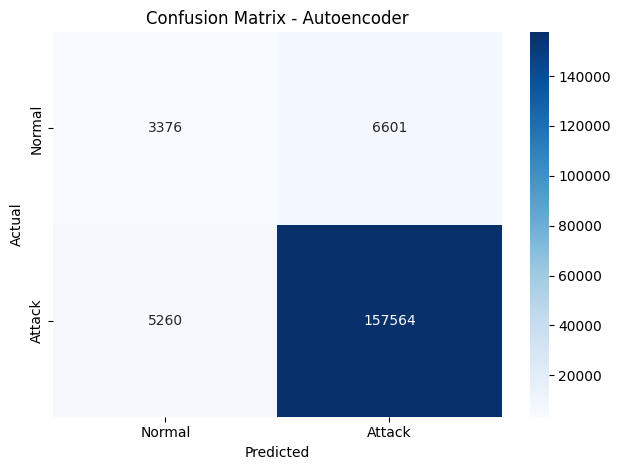

Autoencoder model saved to autoencoder_model.pkl


In [ ]:
# Inference on full set
model.eval()
X_test_tensor = torch.tensor(X_test_ae, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    mse = torch.mean((X_test_tensor - reconstructed)**2, dim=1).cpu().numpy()

# Thresholding (top 5% error as attack)
threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)

# 🧾 Evaluation
print("\n🔹 Autoencoder (Ordinary) Performance:")
print("AUC Score:", roc_auc_score(y_test_ae, mse))
print(classification_report(y_test_ae, y_pred_ae))
# Confusion Matrix
cm_ae = confusion_matrix(y_test_ae, y_pred_ae, labels=[1, 0])
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Autoencoder")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Save the model
import joblib
model_path_ae = 'autoencoder_model.pkl'
joblib.dump(model, model_path_ae)
print(f"Autoencoder model saved to {model_path_ae}")
# Save the reconstruction errors
reconstruction_errors_path = 'reconstruction_errors.npy'
np.save(reconstruction_errors_path, mse)

### Autoencoder Hyperparameter

In [ ]:
# hyperparameter tuning
class TunedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), latent_dim=32, activation='relu'):
        super().__init__()
        act_fn = nn.ReLU() if activation == 'relu' else nn.LeakyReLU()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            act_fn,
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            act_fn,
            nn.Linear(hidden_dims[1], latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            act_fn,
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            act_fn,
            nn.Linear(hidden_dims[0], input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [ ]:
def train_autoencoder(X_train, model,
                       optimizer,
                         loss_fn, 
                         epochs=5, 
                         batch_size=512):
    loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x in loader:
            x = x[0].to(device)
            output = model(x)
            loss = loss_fn(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


In [ ]:
# Config
config = {
    'hidden_dims': (128, 64),
    'latent_dim': 32,
    'activation': 'leakyrelu',
    'optimizer': 'adamw',
    'lr': 1e-4
}

# Init model
input_dim = X_train_ae.shape[1]
model = TunedAutoencoder(input_dim, config['hidden_dims'], config['latent_dim'], config['activation']).to(device)

# Optimizer
optimizers = {
    'adam': torch.optim.Adam,
    'adamw': torch.optim.AdamW,
    'sgd': torch.optim.SGD
}
optimizer = optimizers[config['optimizer']](model.parameters(), lr=config['lr'])

# Train
train_autoencoder(X_train_ae, model, optimizer, nn.MSELoss(), epochs=30)


Epoch 1/30 | Loss: 25.8525
Epoch 2/30 | Loss: 8.6543
Epoch 3/30 | Loss: 5.8552
Epoch 4/30 | Loss: 3.8598
Epoch 5/30 | Loss: 2.9582
Epoch 6/30 | Loss: 2.6116
Epoch 7/30 | Loss: 2.3479
Epoch 8/30 | Loss: 2.1512
Epoch 9/30 | Loss: 1.9110
Epoch 10/30 | Loss: 1.6172
Epoch 11/30 | Loss: 1.3917
Epoch 12/30 | Loss: 1.2470
Epoch 13/30 | Loss: 1.1439
Epoch 14/30 | Loss: 1.0723
Epoch 15/30 | Loss: 1.0110
Epoch 16/30 | Loss: 0.9529
Epoch 17/30 | Loss: 0.8970
Epoch 18/30 | Loss: 0.8436
Epoch 19/30 | Loss: 0.7990
Epoch 20/30 | Loss: 0.7563
Epoch 21/30 | Loss: 0.7212
Epoch 22/30 | Loss: 0.6888
Epoch 23/30 | Loss: 0.6586
Epoch 24/30 | Loss: 0.6303
Epoch 25/30 | Loss: 0.6039
Epoch 26/30 | Loss: 0.5796
Epoch 27/30 | Loss: 0.5580
Epoch 28/30 | Loss: 0.5387
Epoch 29/30 | Loss: 0.5209
Epoch 30/30 | Loss: 0.5053



🔹 Tuned Autoencoder Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    162824
           1       0.49      0.42      0.45      9977

    accuracy                           0.94    172801
   macro avg       0.72      0.70      0.71    172801
weighted avg       0.94      0.94      0.94    172801

AUC: 0.842931035515228


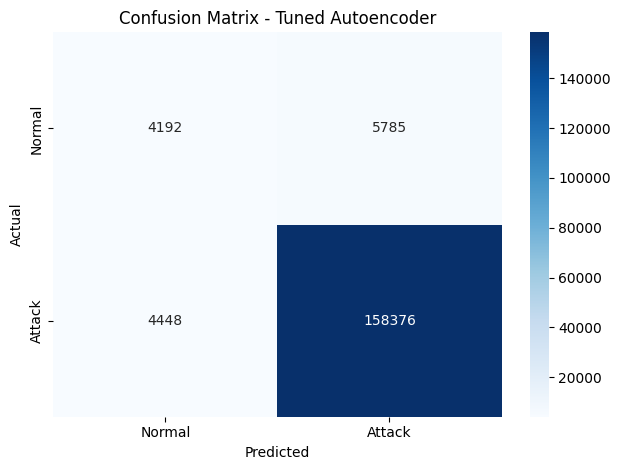

In [ ]:
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test_ae, dtype=torch.float32).to(device)
    recon = model(x_test_tensor)
    mse = torch.mean((x_test_tensor - recon)**2, dim=1).cpu().numpy()

# Threshold and evaluate
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)

print("\n🔹 Tuned Autoencoder Performance:")
print(classification_report(y_test_ae, y_pred))
print("AUC:", roc_auc_score(y_test_ae, mse))
# Confusion Matrix
cm_tuned_ae = confusion_matrix(y_test_ae, y_pred, labels=[1, 0])
sns.heatmap(cm_tuned_ae, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned Autoencoder")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Epoch 1 | Loss: 8.3956
Epoch 2 | Loss: 2.9202
Epoch 3 | Loss: 2.1539
Epoch 4 | Loss: 1.8184
Epoch 5 | Loss: 1.5936
Epoch 6 | Loss: 1.4334
Epoch 7 | Loss: 1.2905
Epoch 8 | Loss: 1.1546
Epoch 9 | Loss: 1.0616
Epoch 10 | Loss: 0.9956
Epoch 11 | Loss: 0.9469
Epoch 12 | Loss: 0.9081
Epoch 13 | Loss: 0.8799
Epoch 14 | Loss: 0.8585
Epoch 15 | Loss: 0.8371
Epoch 16 | Loss: 0.8185
Epoch 17 | Loss: 0.8014
Epoch 18 | Loss: 0.7867
Epoch 19 | Loss: 0.7695
Epoch 20 | Loss: 0.7585
Epoch 21 | Loss: 0.7452
Epoch 22 | Loss: 0.7329
Epoch 23 | Loss: 0.7231
Epoch 24 | Loss: 0.7115
Epoch 25 | Loss: 0.7029
Epoch 26 | Loss: 0.6910
Epoch 27 | Loss: 0.6813
Epoch 28 | Loss: 0.6747
Epoch 29 | Loss: 0.6684
Epoch 30 | Loss: 0.6611


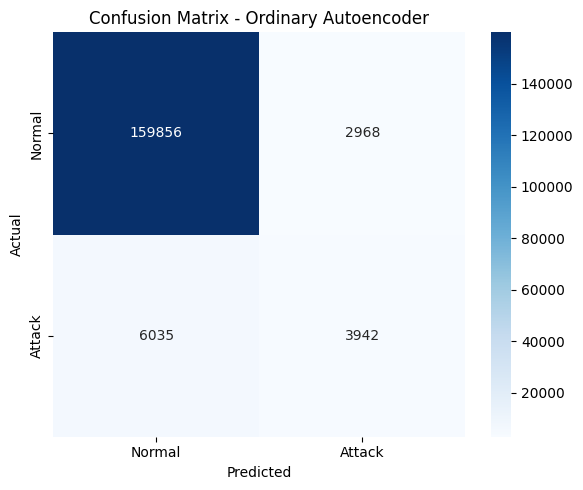

('              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97    162824\n           1       0.57      0.40      0.47      9977\n\n    accuracy                           0.95    172801\n   macro avg       0.77      0.69      0.72    172801\nweighted avg       0.94      0.95      0.94    172801\n',
 0.8267635002356745,
 0.01377934031188488)

In [ ]:

# Basic Autoencoder class without tuning (but with dropout and HuberLoss for robustness)
class OrdinaryAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(OrdinaryAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Training function with fixed epochs and basic validation feedback
def train_ordinary_autoencoder(X_train, model, optimizer, loss_fn, epochs=30, batch_size=256):
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x in train_loader:
            x = x[0].to(device)
            output = model(x)
            loss = loss_fn(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        history.append(total_loss)
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")
    return model, history

# Prepare device and data split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
split = int(0.8 * len(X_train_ae))
X_train_sub = X_train_ae[:split]

# Train ordinary autoencoder
ordinary_model = OrdinaryAutoencoder(input_dim=X_train_ae.shape[1]).to(device)
optimizer = torch.optim.Adam(ordinary_model.parameters(), lr=1e-3)
loss_fn = nn.HuberLoss()
ordinary_model, loss_history = train_ordinary_autoencoder(X_train_sub, ordinary_model, optimizer, loss_fn)

# Evaluate reconstruction on test set
ordinary_model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test_ae, dtype=torch.float32).to(device)
    recon = ordinary_model(x_test_tensor)
    mse = torch.mean((x_test_tensor - recon) ** 2, dim=1).cpu().numpy()

# Threshold: pick best based on F1
thresholds = np.percentile(mse, np.arange(80, 99, 1))
results = []
for thresh in thresholds:
    y_pred = (mse > thresh).astype(int)
    report = classification_report(y_test_ae, y_pred, output_dict=True)
    results.append({
        "threshold": thresh,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1": report['1']['f1-score']
    })

best_result = max(results, key=lambda x: x['f1'])
best_thresh = best_result['threshold']
y_pred_best = (mse > best_thresh).astype(int)

# Final reporting
final_report = classification_report(y_test_ae, y_pred_best)
conf_matrix = confusion_matrix(y_test_ae, y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ordinary Autoencoder")
plt.tight_layout()
plt.show()

final_report, roc_auc_score(y_test_ae, mse), best_thresh


In [ ]:
#classification report
print("🔹 ordinary Autoencoder Performance:")
print(final_report)
print("AUC:", roc_auc_score(y_test_ae, mse))

🔹 ordinary Autoencoder Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    162824
           1       0.57      0.40      0.47      9977

    accuracy                           0.95    172801
   macro avg       0.77      0.69      0.72    172801
weighted avg       0.94      0.95      0.94    172801

AUC: 0.8267635002356745


Epoch 1 | Loss: 9.5811 | Val AUC: 0.7418
Epoch 2 | Loss: 2.1956 | Val AUC: 0.7755
Epoch 3 | Loss: 1.4939 | Val AUC: 0.8104
Epoch 4 | Loss: 1.1128 | Val AUC: 0.8478
Epoch 5 | Loss: 0.9181 | Val AUC: 0.8646
Epoch 6 | Loss: 0.8028 | Val AUC: 0.8676
Epoch 7 | Loss: 0.7230 | Val AUC: 0.8765
Epoch 8 | Loss: 0.6592 | Val AUC: 0.8800
Epoch 9 | Loss: 0.6091 | Val AUC: 0.8861
Epoch 10 | Loss: 0.5682 | Val AUC: 0.8863
Epoch 11 | Loss: 0.5338 | Val AUC: 0.8907
Epoch 12 | Loss: 0.5042 | Val AUC: 0.8936
Epoch 13 | Loss: 0.4771 | Val AUC: 0.8970
Epoch 14 | Loss: 0.4556 | Val AUC: 0.8959
Epoch 15 | Loss: 0.4353 | Val AUC: 0.8997
Epoch 16 | Loss: 0.4173 | Val AUC: 0.8981
Epoch 17 | Loss: 0.4007 | Val AUC: 0.9029
Epoch 18 | Loss: 0.3857 | Val AUC: 0.9033
Epoch 19 | Loss: 0.3722 | Val AUC: 0.9051
Epoch 20 | Loss: 0.3600 | Val AUC: 0.9089
Epoch 21 | Loss: 0.3478 | Val AUC: 0.9058
Epoch 22 | Loss: 0.3378 | Val AUC: 0.9065
Epoch 23 | Loss: 0.3283 | Val AUC: 0.9091
Epoch 24 | Loss: 0.3194 | Val AUC: 0.9047
E

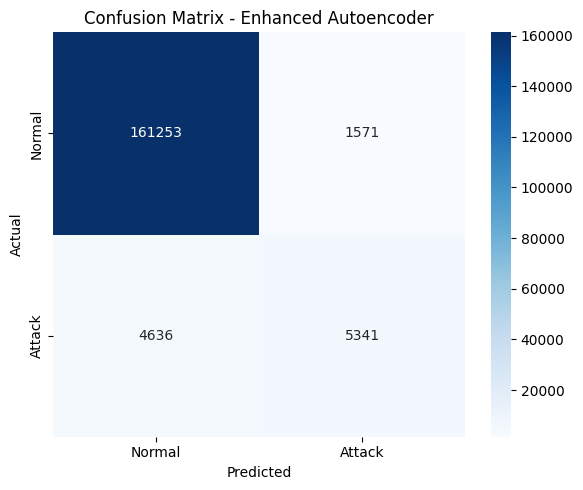

('              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98    162824\n           1       0.77      0.54      0.63      9977\n\n    accuracy                           0.96    172801\n   macro avg       0.87      0.76      0.81    172801\nweighted avg       0.96      0.96      0.96    172801\n',
 0.9472301657025426,
 0.00462944433093071)

In [ ]:
# Define a deeper and enhanced autoencoder with dropout and layer norm
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=(512, 128, 64), latent_dim=32, activation='relu'):
        super().__init__()
        act_fn = nn.ReLU() if activation == 'relu' else nn.LeakyReLU()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            act_fn,
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.LayerNorm(hidden_dims[1]),
            act_fn,
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            act_fn,
            nn.Linear(hidden_dims[2], latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[2]),
            act_fn,
            nn.Linear(hidden_dims[2], hidden_dims[1]),
            act_fn,
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            act_fn,
            nn.Linear(hidden_dims[0], input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Train function using HuberLoss and validation AUC
def train_autoencoder(X_train, X_val, y_val, model, optimizer, loss_fn, max_epochs=100, batch_size=256, patience=15):
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    best_auc = 0
    best_model_state = None
    history = []
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for x in train_loader:
            x = x[0].to(device)
            output = model(x)
            loss = loss_fn(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            recon = model(val_tensor)
            mse_tune = torch.mean((val_tensor - recon) ** 2, dim=1).cpu().numpy()
            auc = roc_auc_score(y_val, mse_tune)
            history.append(auc)
            print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Val AUC: {auc:.4f}")

            if auc > best_auc:
                best_auc = auc
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    return model, history

# Prepare data splits
split = int(0.8 * len(X_train_ae))
X_train_sub = X_train_ae[:split]
X_val_sub = X_train_ae[split:]
y_val_sub = np.zeros(len(X_val_sub))
X_val_combined = np.vstack((X_val_sub, X_test_ae[y_test_ae == 1]))
y_val_combined = np.hstack((y_val_sub, np.ones(sum(y_test_ae == 1))))

# Initialize and train enhanced autoencoder
enhanced_ae = EnhancedAutoencoder(input_dim=X_train_ae.shape[1]).to(device)
optimizer = torch.optim.Adam(enhanced_ae.parameters(), lr=1e-4)
loss_fn = nn.HuberLoss()
enhanced_ae, enhanced_history = train_autoencoder(X_train_sub, X_val_combined, y_val_combined, enhanced_ae, optimizer, loss_fn)

# Inference and threshold tuning
enhanced_ae.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test_ae, dtype=torch.float32).to(device)
    recon = enhanced_ae(x_test_tensor)
    mse_tune = torch.mean((x_test_tensor - recon) ** 2, dim=1).cpu().numpy()

# Try multiple thresholds and pick best based on F1
thresholds = np.percentile(mse_tune, np.arange(80, 99, 1))
results = []
for thresh in thresholds:
    y_pred = (mse_tune > thresh).astype(int)
    report = classification_report(y_test_ae, y_pred, output_dict=True)
    results.append({
        "threshold": thresh,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1": report['1']['f1-score']
    })

# Choose threshold with highest F1
best_result = max(results, key=lambda x: x['f1'])
best_thresh_tune = best_result['threshold']
y_pred_best_tune = (mse_tune > best_thresh_tune).astype(int)

# Final evaluation
final_report = classification_report(y_test_ae, y_pred_best_tune)
conf_matrix = confusion_matrix(y_test_ae, y_pred_best_tune)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Enhanced Autoencoder")
plt.tight_layout()
plt.show()

final_report, roc_auc_score(y_test_ae, mse_tune), best_thresh_tune


In [ ]:
# classification report
print("🔹 Enhanced Autoencoder Performance:")
print(final_report)
print("AUC:", roc_auc_score(y_test_ae, mse))



🔹 Enhanced Autoencoder Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    162824
           1       0.77      0.54      0.63      9977

    accuracy                           0.96    172801
   macro avg       0.87      0.76      0.81    172801
weighted avg       0.96      0.96      0.96    172801

AUC: 0.8267635002356745


In [ ]:
# Save trained PyTorch models
torch.save(ordinary_model.state_dict(), "ordinary_autoencoder.pth")
torch.save(enhanced_ae.state_dict(), "enhanced_autoencoder.pth")


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
g

### LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Load data
# Drop unnecessary columns
df = df.drop(columns=["Row", "Date", "Time", "Timestamp", "Day"], errors="ignore")

# Separate features and labels
X_full = df.drop(columns=["Attack LABLE (1:No Attack, -1:Attack)"]).values
y_full = df["Attack LABLE (1:No Attack, -1:Attack)"].values

# 🧹 Impute and scale
X_full = SimpleImputer(strategy="mean").fit_transform(X_full)
X_scaled = MinMaxScaler().fit_transform(X_full)

# Combine and remove any NaNs
full_data = np.hstack((X_scaled, y_full.reshape(-1, 1)))
full_data_clean = full_data[~np.isnan(full_data).any(axis=1)]
X_scaled = full_data_clean[:, :-1]
y_full = full_data_clean[:, -1]
y_binary = np.where(y_full == -1, 1, 0)

# 📦 Sequence builder
def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# 🧠 Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_binary)

# 🔀 Train-test split
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test_lstm = y_seq[:split_idx], y_seq[split_idx:]

# 🧲 Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train.astype(int))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# 📊 DataLoaders
batch_size = 128
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_lstm, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: [47 48 83 84]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
d

NameError: name 'd' is not defined

In [ ]:
class LSTMCNNOrdinary(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.conv = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        conv_input = lstm_out.permute(0, 2, 1)
        conv_out = self.pool(torch.relu(self.conv(conv_input))).squeeze(-1)
        return torch.sigmoid(self.fc(conv_out)).squeeze(-1)

model_basic = LSTMCNNOrdinary(input_size=X_train.shape[2]).to(device)
criterion = nn.BCELoss(weight=class_weights_tensor[1].to(device))
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    model_basic.train()
    losses = []
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_basic(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"[Ordinary] Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")

# Evaluate
model_basic.eval()
all_preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        preds = model_basic(Xb.to(device))
        all_preds.extend(preds.cpu().numpy())

y_pred_lstm_basic = (np.array(all_preds) >= 0.5).astype(int)
print("📊 Final Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm_basic))
print("AUC:", roc_auc_score(y_test_lstm, all_preds))


[Ordinary] Epoch 1: Loss = 1.3357
[Ordinary] Epoch 2: Loss = 0.6921
[Ordinary] Epoch 3: Loss = 0.5990
[Ordinary] Epoch 4: Loss = 0.5614
[Ordinary] Epoch 5: Loss = 0.5380
[Ordinary] Epoch 6: Loss = 0.5140
[Ordinary] Epoch 7: Loss = 0.5004
[Ordinary] Epoch 8: Loss = 0.4809
[Ordinary] Epoch 9: Loss = 0.4718
[Ordinary] Epoch 10: Loss = 0.4592
[Ordinary] Epoch 11: Loss = 0.4535
[Ordinary] Epoch 12: Loss = 0.4427
[Ordinary] Epoch 13: Loss = 0.4401
[Ordinary] Epoch 14: Loss = 0.4330
[Ordinary] Epoch 15: Loss = 0.4323
[Ordinary] Epoch 16: Loss = 0.4201
[Ordinary] Epoch 17: Loss = 0.4168
[Ordinary] Epoch 18: Loss = 0.4128
[Ordinary] Epoch 19: Loss = 0.4068
[Ordinary] Epoch 20: Loss = 0.4010
📊 Final Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     32988
           1       0.73      0.51      0.60      1567

    accuracy                           0.97     34555
   macro avg       0.85      0.75      0.79     34555
weigh

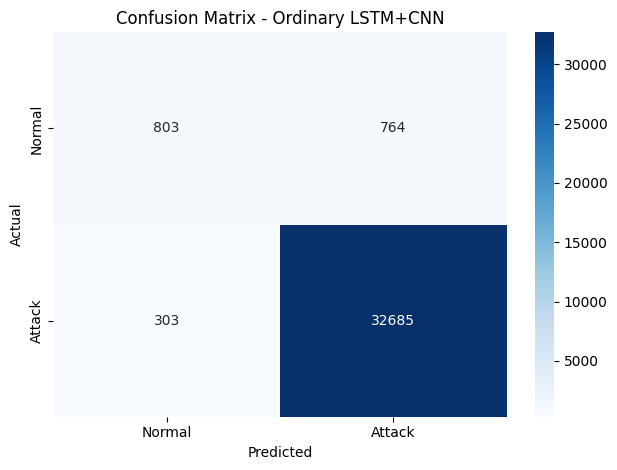

In [ ]:
#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_basic = confusion_matrix(y_test_lstm, y_pred_lstm_basic, labels=[1, 0])
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Ordinary LSTM+CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
class LSTMCNNTuned(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.conv = nn.Conv1d(64, 32, 3)
        self.norm = nn.LayerNorm(28)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = self.norm(x)
        x = self.dropout(x)
        x = self.pool(x).squeeze(-1)
        return torch.sigmoid(self.fc(x)).squeeze(-1)

model_tuned = LSTMCNNTuned(X_train.shape[2]).to(device)
criterion = nn.BCELoss(weight=class_weights_tensor[1].to(device))
optimizer = torch.optim.AdamW(model_tuned.parameters(), lr=3e-4)

# Training loop with best model selection
best_auc = 0
best_model_state = None
for epoch in range(40):
    model_tuned.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_tuned(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    # Evaluate every epoch
    model_tuned.eval()
    all_preds = []
    with torch.no_grad():
        for Xb, _ in test_loader:
            preds = model_tuned(Xb.to(device))
            all_preds.extend(preds.cpu().numpy())

    val_auc = roc_auc_score(y_test_lstm, all_preds)
    print(f"[Tuned] Epoch {epoch+1}: AUC = {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model_tuned.state_dict()

# Load best
model_tuned.load_state_dict(best_model_state)

# Final predictions
model_tuned.eval()
final_preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        preds = model_tuned(Xb.to(device))
        final_preds.extend(preds.cpu().numpy())

y_pred_lstm_tuned = (np.array(final_preds) >= 0.5).astype(int)
print("📊 Final Tuned Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm_tuned))
print("AUC:", roc_auc_score(y_test_lstm, final_preds))


[Tuned] Epoch 1: AUC = 0.8517
[Tuned] Epoch 2: AUC = 0.9472
[Tuned] Epoch 3: AUC = 0.9549
[Tuned] Epoch 4: AUC = 0.9588
[Tuned] Epoch 5: AUC = 0.9571
[Tuned] Epoch 6: AUC = 0.9456
[Tuned] Epoch 7: AUC = 0.9381
[Tuned] Epoch 8: AUC = 0.9393
[Tuned] Epoch 9: AUC = 0.9113
[Tuned] Epoch 10: AUC = 0.8855
[Tuned] Epoch 11: AUC = 0.9379
[Tuned] Epoch 12: AUC = 0.8643
[Tuned] Epoch 13: AUC = 0.8134
[Tuned] Epoch 14: AUC = 0.8588
[Tuned] Epoch 15: AUC = 0.8953
[Tuned] Epoch 16: AUC = 0.8113
[Tuned] Epoch 17: AUC = 0.8261
[Tuned] Epoch 18: AUC = 0.9175
[Tuned] Epoch 19: AUC = 0.8685
[Tuned] Epoch 20: AUC = 0.7730
[Tuned] Epoch 21: AUC = 0.7478
[Tuned] Epoch 22: AUC = 0.8651
[Tuned] Epoch 23: AUC = 0.7766
[Tuned] Epoch 24: AUC = 0.8696
[Tuned] Epoch 25: AUC = 0.8481
[Tuned] Epoch 26: AUC = 0.8789
[Tuned] Epoch 27: AUC = 0.8319
[Tuned] Epoch 28: AUC = 0.8302
[Tuned] Epoch 29: AUC = 0.9012
[Tuned] Epoch 30: AUC = 0.8602
[Tuned] Epoch 31: AUC = 0.7699
[Tuned] Epoch 32: AUC = 0.7824
[Tuned] Epoch 33:

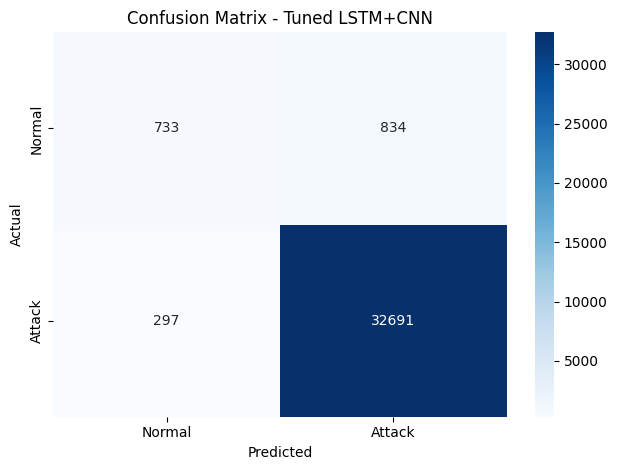

In [ ]:
#Confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test_lstm, y_pred_lstm_tuned, labels=[1, 0])
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned LSTM+CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Hybrid model

In [70]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

# ----- 🔁 Step 1: Normalize AE scores (higher = more anomalous = attack) -----
from sklearn.preprocessing import MinMaxScaler

# Ensure all predictions are on the same test set
X_test = X_test_ae  # Use consistent test set
y_test = y_test_ae  # Use consistent test set

# Get predictions from all models on the same test set
rf_proba = rf_basic.predict_proba(X_test)[:, 1]
rf_tuned_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred_basic = rf_basic.predict(X_test)
y_pred_tuned = best_rf.predict(X_test)

# Scale the autoencoder scores
mse_scaled = MinMaxScaler().fit_transform(mse.reshape(-1, 1)).flatten()
mse_tune_scaled = MinMaxScaler().fit_transform(mse_tune.reshape(-1, 1)).flatten()

# Ensure all predictions have the same length
min_length = min(len(rf_proba), len(rf_tuned_proba), len(mse_scaled), 
                len(mse_tune_scaled), len(all_preds), len(final_preds))

# Truncate all predictions to the same length
rf_proba = rf_proba[:min_length]
rf_tuned_proba = rf_tuned_proba[:min_length]
mse_scaled = mse_scaled[:min_length]
mse_tune_scaled = mse_tune_scaled[:min_length]
all_preds = all_preds[:min_length]
final_preds = final_preds[:min_length]
y_true = y_test[:min_length]

# ----- 🔁 Step 2: Stack inputs -----
stacked_features = np.vstack([
    rf_proba,
    rf_tuned_proba,
    mse_scaled,
    mse_tune_scaled,
    all_preds,
    final_preds
]).T

# ----- 🧠 Step 3a: Logistic Regression Meta-Learner -----
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(stacked_features, y_true)
stacked_preds = meta_model.predict(stacked_features)
stacked_proba = meta_model.predict_proba(stacked_features)[:, 1]

# ----- 🗳️ Step 3b: Weighted Voting -----
weights = {
    "rf": 1.0,
    "rf_tuned": 1.2,
    "ae": 0.8,
    "ae_tuned": 1.2,
    "lstm": 1.2,
    "lstm_tuned": 1.4
}
voted_score = (
    rf_proba * weights["rf"] +
    rf_tuned_proba * weights["rf_tuned"] +
    mse_scaled * weights["ae"] +
    mse_tune_scaled * weights["ae_tuned"] +
    all_preds * weights["lstm"] +
    final_preds * weights["lstm_tuned"]
)
voted_score /= sum(weights.values())
voted_preds = (voted_score > 0.5).astype(int)

# ----- 📊 Step 4: Evaluation -----
def eval_and_report(name, y_true, y_score, y_pred):
    auc = roc_auc_score(y_true, y_score)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🔍 {name} Report:")
    print(classification_report(y_true, y_pred))
    return report, auc, cm

stacked_report, stacked_auc, stacked_cm = eval_and_report("Stacked Ensemble", y_true, stacked_proba, stacked_preds)
voted_report, voted_auc, voted_cm = eval_and_report("Weighted Voting", y_true, voted_score, voted_preds)

# ----- 📈 Step 5: ROC Curve -----
fpr_stack, tpr_stack, _ = roc_curve(y_true, stacked_proba)
fpr_vote, tpr_vote, _ = roc_curve(y_true, voted_score)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr_stack, y=tpr_stack, mode='lines', name='Stacked Ensemble'))
fig.add_trace(go.Scatter(x=fpr_vote, y=tpr_vote, mode='lines', name='Weighted Voting'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Chance'))
fig.update_layout(title='ROC Curves - Hybrid Models',
                  xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
fig.show()

# ----- 🔲 Step 6: Confusion Matrix -----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(stacked_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Stacked Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(voted_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Weighted Voting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ----- 💾 Step 7: Save comparison -----
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score", "AUC"],
    "Stacked Ensemble": [
        stacked_report['1']['precision'],
        stacked_report['1']['recall'],
        stacked_report['1']['f1-score'],
        stacked_auc
    ],
    "Weighted Voting": [
        voted_report['1']['precision'],
        voted_report['1']['recall'],
        voted_report['1']['f1-score'],
        voted_auc
    ]
})
summary_df.to_csv("hybrid_model_summary.csv", index=False)
print("✅ Saved hybrid_model_summary.csv")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 138240 and the array at index 2 has size 172801

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

# ---- Classification Reports ----
rf_report = classification_report(y_test_rf, y_pred_basic, output_dict=True)
rf_tuned_report = classification_report(y_test_rf, y_pred_tuned, output_dict=True)
ae_report = classification_report(y_test_ae, y_pred_best, output_dict=True)
ae_enhanced_report = classification_report(y_test_ae, y_pred_best_tune, output_dict=True)
lstm_report = classification_report(y_test_lstm, y_pred_lstm_basic, output_dict=True)
lstm_tuned_report = classification_report(y_test_lstm, y_pred_lstm_tuned, output_dict=True)

# ---- AUC Scores ----
rf_auc = roc_auc_score(y_test_rf, y_pred_basic)
rf_tuned_auc = roc_auc_score(y_test_rf, y_pred_tuned)
ae_auc = roc_auc_score(y_test_ae, mse)
ae_enhanced_auc = roc_auc_score(y_test_ae, mse_tune)
lstm_auc = roc_auc_score(y_test_lstm, all_preds)
lstm_tuned_auc = roc_auc_score(y_test_lstm, final_preds)

# ---- Prepare Table ----
metrics = ['precision', 'recall', 'f1-score']
comparison_data = {
    'Metric': [],
    'Random Forest': [],
    'Random Forest (Tuned)': [],
    'Autoencoder': [],
    'Enhanced Autoencoder': [],
    'LSTM+CNN': [],
    'LSTM+CNN (Tuned)': []
}

for metric in metrics:
    comparison_data['Metric'].append(f"{metric} (Attack)")
    comparison_data['Random Forest'].append(rf_report['1'][metric])
    comparison_data['Random Forest (Tuned)'].append(rf_tuned_report['1'][metric])
    comparison_data['Autoencoder'].append(ae_report['1'][metric])
    comparison_data['Enhanced Autoencoder'].append(ae_enhanced_report['1'][metric])
    comparison_data['LSTM+CNN'].append(lstm_report['1'][metric])
    comparison_data['LSTM+CNN (Tuned)'].append(lstm_tuned_report['1'][metric])

# Add AUC
comparison_data['Metric'].append("AUC")
comparison_data['Random Forest'].append(rf_auc)
comparison_data['Random Forest (Tuned)'].append(rf_tuned_auc)
comparison_data['Autoencoder'].append(ae_auc)
comparison_data['Enhanced Autoencoder'].append(ae_enhanced_auc)
comparison_data['LSTM+CNN'].append(lstm_auc)
comparison_data['LSTM+CNN (Tuned)'].append(lstm_tuned_auc)

# Add Thresholds (Autoencoder only)
comparison_data['Metric'].append("Threshold")
comparison_data['Random Forest'].append("N/A")
comparison_data['Random Forest (Tuned)'].append("N/A")
comparison_data['Autoencoder'].append(best_thresh)
comparison_data['Enhanced Autoencoder'].append(best_thresh_tune)
comparison_data['LSTM+CNN'].append("N/A")
comparison_data['LSTM+CNN (Tuned)'].append("N/A")

# ---- Save & Show ----
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv("model_comparison_summary.csv", index=False)

print("✅ Summary saved as: model_comparison_summary.csv")
comparison_df



✅ Summary saved as: model_comparison_summary.csv


,Metric,Random Forest,Random Forest (Tuned),Autoencoder,Enhanced Autoencoder,LSTM+CNN,LSTM+CNN (Tuned)
0,precision (Attack),0.719383,0.719572,0.484568,0.774562,0.719383,0.719572
1,recall (Attack),0.476069,0.471602,0.503558,0.536534,0.476069,0.471602
2,f1-score (Attack),0.572965,0.569776,0.493881,0.633941,0.572965,0.569776
3,AUC,0.733624,0.731436,0.864851,0.945223,0.795495,0.795495
4,Threshold,N/A,N/A,0.011184,0.005019,N/A,N/A


In [ ]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve

# Compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_pred_basic)
fpr_rf_tuned, tpr_rf_tuned, _ = roc_curve(y_test_rf, y_pred_tuned)
fpr_ae, tpr_ae, _ = roc_curve(y_test_ae, mse)
fpr_ae_tuned, tpr_ae_tuned, _ = roc_curve(y_test_ae, mse_tune)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, y_pred_lstm_basic)
fpr_lstm_tuned, tpr_lstm_tuned, _ = roc_curve(y_test_lstm, y_pred_lstm_tuned)

# Create interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines', name='Random Forest'))
fig.add_trace(go.Scatter(x=fpr_rf_tuned, y=tpr_rf_tuned, mode='lines', name='RF Tuned'))
fig.add_trace(go.Scatter(x=fpr_ae, y=tpr_ae, mode='lines', name='Autoencoder'))
fig.add_trace(go.Scatter(x=fpr_ae_tuned, y=tpr_ae_tuned, mode='lines', name='Enhanced AE'))
fig.add_trace(go.Scatter(x=fpr_lstm, y=tpr_lstm, mode='lines', name='LSTM+CNN'))
fig.add_trace(go.Scatter(x=fpr_lstm_tuned, y=tpr_lstm_tuned, mode='lines', name='LSTM+CNN (Tuned)'))

# Add chance diagonal
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                         line=dict(dash='dash'), name='Chance'))

# Update layout
fig.update_layout(title='Interactive ROC Curves (All Models)',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  template='plotly_white',
                  legend=dict(x=0.02, y=0.98))

fig.show()


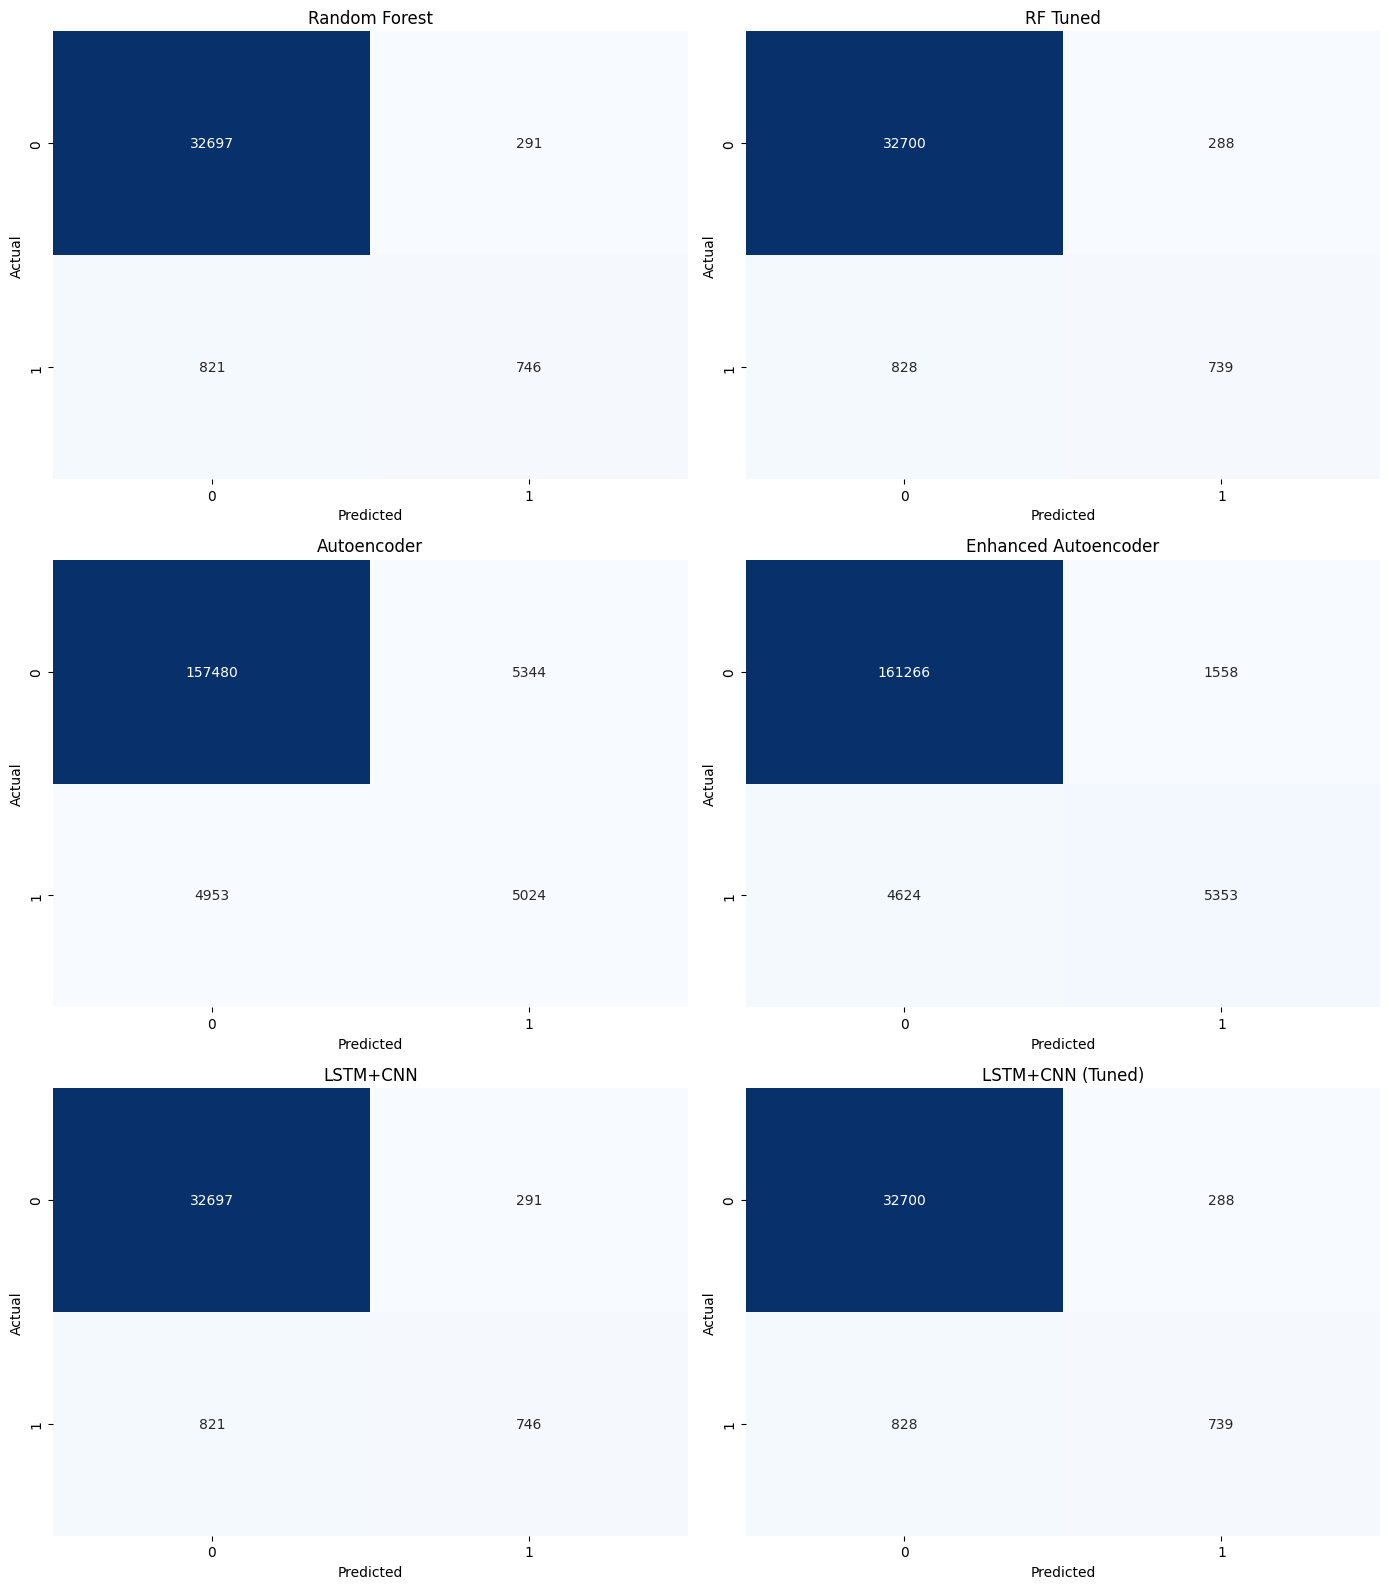

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define titles and confusion matrices
titles = [
    'Random Forest', 
    'RF Tuned', 
    'Autoencoder', 
    'Enhanced Autoencoder',
    'LSTM+CNN', 
    'LSTM+CNN (Tuned)'
]

matrices = [
    confusion_matrix(y_test_rf, y_pred_basic),
    confusion_matrix(y_test_rf, y_pred_tuned),
    confusion_matrix(y_test_ae, y_pred_best),
    confusion_matrix(y_test_ae, y_pred_best_tune),
    confusion_matrix(y_test_lstm, y_pred_lstm_basic),
    confusion_matrix(y_test_lstm, y_pred_lstm_tuned)
]

# Create 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

for ax, matrix, title in zip(axes.flat, matrices, titles):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()
